# Classifying Wikipedia Comments with BERT

This Notebook will show you how to fine-tune BERT for **multi-label text classification** tasks, meaning that each sample in the dataset can belong to more than one category (or no category!). 

We'll be using the *Wikipedia Toxic Comments Challenge* dataset, which contains a large number of user-written comments, and where each comment can be tagged with multiple labels. 

The dataset has **6** different labels corresponding to different types of awfulness ("toxic", "obscene", "insult", ...), and each comment can be tagged with one or more labels, or no labels at all. 

This is a slightly different task than "multiclass" classification, where there are multiple categories, but each sample only belongs to one category.

The huggingface `transformers` library has built-in support for multiclass, but not multi-label, so we'll be defining a custom class here to do it!

At first, let's look at the differences in a multi-label vs. multi-class architecture.

At the most basic level, in *multiclass* our target is a one-hot vector that must have one and only one positive class. For multi-label our target is a one-hot vector that can have a) no positive classes, b) one positive class, or c) multiple positive classes.

![One Hot Vectors](https://drive.google.com/uc?id=1cPFTlbBVT9I2wx06M1MkuAToXfpXruuS)

In both cases, the embedding for the `[CLS]` token, after being "enhanced" by all 12 of BERT's encoder layers, is fed into a classifier which makes our predictions.


![Illustration of CLS token purpose](https://drive.google.com/uc?export=view&id=1ck4mvGkznVJfW3hv6GUqcdGepVTOx7HE)


The difference between how we handle multilabel vs multiclass tasks is just in the classifier at the very end! 

In both cases, we use a simple linear classifier, which has a `[768 x 6]` weight matrix. We multiply the `[CLS]` embedding (length 768) against this matrix to produce 6 logit values (one for each class).

The difference between multiclass and multi-label is what we do with those 6 logits--we use a different *activation function* and *loss function*.

## Multiclass

For multiclass, we use the **SoftMax activation** function with **Cross-Entropy Loss**.

The below illustration shows how the final `[CLS]` token embedding is multiplied by the classifier weights to produce the logits, then sent through the SoftMax activation function.

![Multiclass Classifier with SoftMax](https://drive.google.com/uc?id=1X4hGAlKoTkoQlbLx3w2Iye3QaOIOuecQ)

The result is a distribution of scores across the classes that will always add up to 1.0. 

Using softmax, the probability of one class affects the probability of the other classes in a big way. This works out well because there is only one correct answer, so if one score is very likely we want to make the other scores very unlikely. 

When we want to predict the label for a new piece of input text, we simply assign it the highest scoring class.

## Multi-Label

For multi-label, this presents a problem. Since an example can belong to multiple classes, we don't want the high probability that our example is one class to negatively affect the probability that it could be in the other classes. 

For multilabel, we will use the **sigmoid activation** function with **Binary Cross-Entropy Loss**. 

Here is the same illustration, this time with sigmoid activation.

![Multilabel Classifier with sigmoid](https://drive.google.com/uc?id=1XAJfd9pVAIqIX43Ih13X4d4DjWEe7tys)


When we want to predict the labels for a new piece of input text, we just assign all labels whose scores are greater than some threshold. The sigmoid function always outputs values in the range 0 - 1.0, so 0.5 is a reasonable choice for our threshold.

The `BertForSequenceClassification` class is the closest to what we are looking for; for some reason, though, it does not support multi-label classification, and so we'll need to define our own model: **BertForMultiLabelSequenceClassification**.

With the theory out of the way, now we can define our new architecture in code.

We will still be relying heavily on the `transformers` library, so we'll need to install it before we can define our model. 

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 5.8MB/s 
     |████████████████████████████████| 3.3MB 53.6MB/s 
     |████████████████████████████████| 901kB 52.1MB/s 


We can get most of what we need for our model definition by simplying copying the source code for `BertForSequenceClassification` from `modeling_bert.py` [here](https://github.com/huggingface/transformers/blob/0735def8e1200ed45a2c33a075bc1595b12ef56a/src/transformers/modeling_bert.py#L1267).

`BertForSequenceClassification` calls down to an instance of `BertModel`, which implements all of BERT's non-task-specific architecture. We just need to define a `forward` function which calls down to `BertModel`, and then adds on our final multi-label classification step.

In [ ]:
import os
import time
import torch
import gdown
import random
import logging
import textwrap
import datetime
import numpy as np
import pandas as pd
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer
from torch.nn import BCEWithLogitsLoss
from sklearn.metrics import roc_auc_score
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split
from transformers import BertPreTrainedModel, BertModel, AdamW
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [ ]:
class BertForMultiLabelSequenceClassification(BertPreTrainedModel):
    '''
    This custom class closely resembles BertForSequenceClassification, which
    supports multiclass classification, but not multi-label.
    This modified version supports data points with multiple labels.
    '''

    def __init__(self, config):
        '''
        Class initializer, called when we create a new instance of this class.
        '''

        # Call the init function of the parent class (BertPreTrainedModel)        
        super().__init__(config)
       
        # Store the number of labels.
        self.num_labels = config.num_labels
        
        # Create a `BertModel`--this implements all of BERT except for the final
        # task-specific output layer (which is what we'll do here in `forward`). 
        self.bert = BertModel(config)

        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        # Create a [768 x 6] weight matrix to use as our classifier.
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        # Initialize model weights (inherited function).
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
    ):
        '''
        This function defines what happens on a forward pass of our model, both
        for training and evaluation. For example, when we call 
            `model(b_input_ids, ...)`
        during our training loop, it results in a call to this `forward`
        function.
        '''

        # ====================
        #   Run Through BERT
        # ====================

        # All of BERT's (non-task-specific) architecture is implemented by the
        # BertModel class. Here we pass all of the inputs through our BertModel
        # instance. 
        outputs = self.bert(
            input_ids,                      # The input sequence
            attention_mask=attention_mask,  # Mask out any [PAD] tokens.
            token_type_ids=token_type_ids,  # Identify segment A vs. B
            position_ids=position_ids,      # TODO...
            head_mask=head_mask,            # TODO...
            inputs_embeds=inputs_embeds,    # Presumably the initial embeddings
                                            # for the tokens in our sequence.
            output_attentions=output_attentions, # Boolean, whether to return
                                                 # all of the attention scores.
            output_hidden_states=output_hidden_states, # Whether to return
                                                       # embeddings from all 12
                                                       # layers.
        )

        # Side note: It confused me to see us *invoking* an instance of a class
        # (calling self.bert(...)) as if it were a function! I learned that in 
        # Python, an instance of a class can be callable if the class defines a 
        # `__call__` method! 
        # BertModel ultimately inherits from torch.nn.Module, which I imagine 
        # implements a `__call__` method that allows PyTorch to work its magic.

        # The forward pass of 'BertModel' (the call to `self.bert`) returns two
        # items.

        # The first output is the final embeddings taken from the output of 
        # the final BERT encoder layer.
        #
        # `final_embeddings` has dimensions:
        #    [ batch size  x  sequence length  x  768]
        #      (768 is the length of the embeddings in BERT-base)
        #
        # I've included this here for informational purposes, but we won't 
        # actually use the `final_embeddings` anywhere here!
        final_embeddings = outputs[0]

        # ===========================
        #   Apply Output Classifier
        # ===========================

        # The second output is the activated form of the final [CLS] embedding. 
        # This comes from the so-called "pooling layer" that BERT has on its 
        # output which is only applied to the [CLS] token and none of the
        # others.
        #
        # You can see the definition of BertPooler.forward here:
        # https://github.com/huggingface/transformers/blob/0735def8e1200ed45a2c33a075bc1595b12ef56a/src/transformers/modeling_bert.py#L506
        #
        # It takes the final embedding for the [CLS] token (and *only* that
        # token), multiplies it with a [768 x 768] weight matrix, and then
        # applies tanh activation to each of the 768 features in the embedding.
        activated_cls = outputs[1]

        activated_cls = self.dropout(activated_cls)
        
        # Send it through our linear "classifier". The "classifier" is actually
        # just a [768 x 6] weight matrix, with *no activation function*. 
        # Multiplying the activated CLS embedding with this matrix results in
        # a vector with 6 values, which are the scores for each of our classes.
        # Because we have not applied the activation function, these output 
        # values are referred to as "logits". 
        # When performing evaluation (not training), the logits are adequate for
        # making a classification, since the activation function does not change
        # the ranking of the results.
        # So, in evaluation mode, we are done here!
        logits = self.classifier(activated_cls)
        
        # ===================
        #   Training Mode
        # ===================

        # If labels for the inputs have been provided, we take that to mean that
        # we are in training mode, and we need to calculate the loss function.
        if labels is not None:
            
            # The Binary Cross-Entropy Loss function is defined for us in 
            # PyTorch by the `BCEWithLogitsLoss` class.
            #
            # This loss function will:
            #   1. Apply the sigmoid activation to each of our 6 logit values.
            #   2. Feed those outputs, along with the correct labels, through 
            #      the binary cross entropy loss function to calculate a 
            #      (single?) loss value for the sample.
            loss_fct = BCEWithLogitsLoss()

            # Call the loss function, giving it the `logits` and the correct
            # `labels`.
            loss = loss_fct(logits.view(-1, self.num_labels), # The logits
                            labels.view(-1, self.num_labels)) # The labels

            # What's view(-1, ...)?
            # The `view` function is used to reshape tensors. `-1` tells PyTorch
            # to infer that dimension by dividing the total number of elements
            # by the other dimensions.
            # For batched input, this call to view is not necessary. Both
            # `logits` and `labels` are already [16 x 6] here.
            # Perhaps it's there to re-shape the tensors if you're only
            # evaluating on a single input instead of a batch?

            # Output is (loss, logits, <bonus returns>)
            # The 'bonus return' values are the attentions and the hidden states
            # from all 12 layers, but these are only returned by `BertModel` if
            # the appropriate flags are set. 
            return ((loss, logits) + outputs[2:])

        # ===================
        #   Evaluation Mode
        # ===================

        # Otherwise, in evaluation mode...
        else:
        
            # Output is (logits, <bonus returns>)
            # Again, the logits are adequate for classification, so we don't
            # bother applying the (sigmoid) activation function here.
            return ((logits,) + outputs[2:])

## Retrieve & Inspect Dataset

The Toxic Comments Challenge on Kaggle (TODO) tasks competitors with classifying user-written comments (from Wikipedia edit pages) as containing depending on whether they 
toxic             15294
severe_toxic       1595
obscene            8449
threat              478
insult             7877
identity_hate      1405

In [ ]:
# Model files and their Google Drive IDs.
# These are tuples of the form (local_file_name, drive_id).
files = [
     ('./data/train.csv',     '1kacByJji9j_dzVcuV8Dl7sZKH0pLkwZZ'),
     ('./data/test.csv',     '1ZkfmPRFiEVuZ2GlNKw3tZZkn9WwxqADp'),
     ('./data/sample_submission.csv', '1QPw2EaY3mKqcMcQYss6FebJXtCRMHN-1'),
     ('./data/test_labels.csv', '18Pkeuvm8_6c2iz-vymM8FZ5dyMUONU1j'),
]

# Make the '/data/' subdirectory.
if not os.path.exists('./data/'):
    os.mkdir('./data/')

print('Downloading dataset files...')

# For each of the files...
for pair in files:
    # Get the local filename.
    output = pair[0]
    
    # Get the ID of the file on Google Drive.
    file_id = pair[1]
    
    # Download the file.
    gdown.download('https://drive.google.com/uc?id=' + file_id, output, 
                   quiet=False)
    
print('DONE.')

Downloading...
From: https://drive.google.com/uc?id=1kacByJji9j_dzVcuV8Dl7sZKH0pLkwZZ
To: /content/data/train.csv
68.8MB [00:01, 58.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZkfmPRFiEVuZ2GlNKw3tZZkn9WwxqADp
To: /content/data/test.csv
60.4MB [00:01, 33.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QPw2EaY3mKqcMcQYss6FebJXtCRMHN-1
To: /content/data/sample_submission.csv
6.28MB [00:00, 23.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=18Pkeuvm8_6c2iz-vymM8FZ5dyMUONU1j
To: /content/data/test_labels.csv
4.98MB [00:00, 16.4MB/s]

DONE.


In [ ]:
train = pd.read_csv('./data/train.csv')
print(f'There are {len(train):,} training examples.')
train.head()

There are 159,571 training examples.


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80) 

# Filter to just the "insult" comments.
insults = train.loc[train.insult == 1]['comment_text']

# Randomly choose some examples.
for i in range(5):
    j = random.choice(insults.index)
    
    print('')
    print(wrapper.fill(insults[j]))
    print('')


hey fuck you i went to this school and its awesome so fuck you bitch!
74.244.182.33


Actually fuck it. You're all gay nerds who butt fuck each other. I'm gonna go
get laid. Btw homos go to hell.


"  I am Not Your Son.These are not ""unfounded accusations"", there are
thousands upon thousands of us who have lost friends and family to the cult - I
am just one of many. You, on the other hand, are a fool. I'd also suggest that
you may be a fucking retard, but that would be cruel to the retards to compare
them with you. "


caden s should b shot in the head 100x u best shut up u piece of dog shitt u no
nuthin u stupid piece of shitt larry king  is victim


Stupid Liberals!!!!!!!!!!!!!!!!!!!!!!!!



## Class Distribution

To analyze the distribution of the labels, let's first explicitly flag the comments which are not toxic (have no labels set to 1).

In [ ]:
# These are the six possible labels.
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Select just the labels (not the text), and for every row, check whether any
# of the labels are "1".
has_labels = train[label_cols].any(axis=1)

# Add a new column indicating which samples have no toxic labels.
train['none'] = 1 - has_labels

# Add the 'none' column to our list of label names.
label_cols.append('none')

# Tally up each label separately.
label_counts = train[label_cols].sum(axis=0)

print(label_counts)

print(f"{label_counts['none'] / len(train):.1%} of the comments are safe.")

toxic             15294
severe_toxic       1595
obscene            8449
threat              478
insult             7877
identity_hate      1405
none             143346
dtype: int64
89.8% of the comments are safe.


Text(0, 0.5, '# of Training Samples')

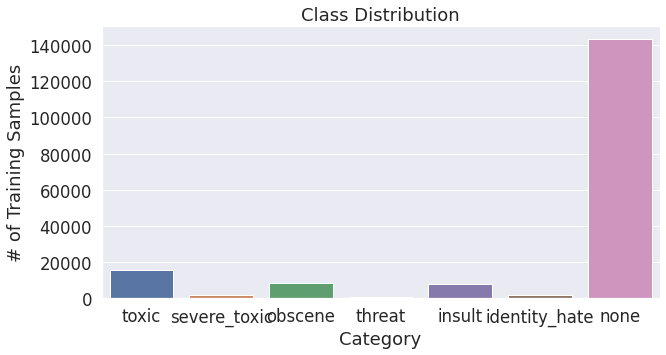

In [ ]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Plot the number of tokens of each length.
sns.barplot(x=label_cols, y=label_counts)
plt.title('Class Distribution')
plt.xlabel('Category')
plt.ylabel('# of Training Samples')

Based on the above, if we just predicted "not toxic" for *every single training sample*, we would get ~90% accuracy on the training set! So we'll have to be careful in how we interpret our accuracy on this task to make sure we're actually doing better than this.

## Tokenization & Truncation

We'll need to tokenize all of the text in our dataset, using BERT's own tokenizer, in order to feed the text into BERT for training. 

Before we do that, we have an important decision to make about the maximum "sequence length" (the number of tokens in an input sentence/passage). BERT is limited to a maximum input length of 512 tokens. Beyond that, long input sequences mean long training times and potential GPU memory issues. 

For these reasons, we'll be truncating some of the text samples to a shorter length. To decide on this length, we'll start by exploring the lengths of the text samples in our dataset.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# By default, the tokenizer will spit out a warning whenever we tokenize a 
# sample which ends up being more than 512 tokens. We don't care about that for
# now, though, and this cell will produce a lot of those warnings! So we'll 
# adjust the logging settings to suppress those warnings and keep the output
# cell cleaner.
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

# Record the length of each sequence (in terms of BERT tokens).
lengths = []

print('Tokenizing comments...')

# For every sentence...
for index, row in train.iterrows():
    
    # Report progress.
    if ((len(lengths) % 20000) == 0):
        print(f'  Tokenized {len(lengths):,} comments.')
    
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        row['comment_text'],     # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    # Record the non-truncated length.
    lengths.append(len(encoded_sent))

print('DONE.')


Tokenizing comments...
  Tokenized 0 comments.
  Tokenized 20,000 comments.
  Tokenized 40,000 comments.
  Tokenized 60,000 comments.
  Tokenized 80,000 comments.
  Tokenized 100,000 comments.
  Tokenized 120,000 comments.
  Tokenized 140,000 comments.
DONE.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


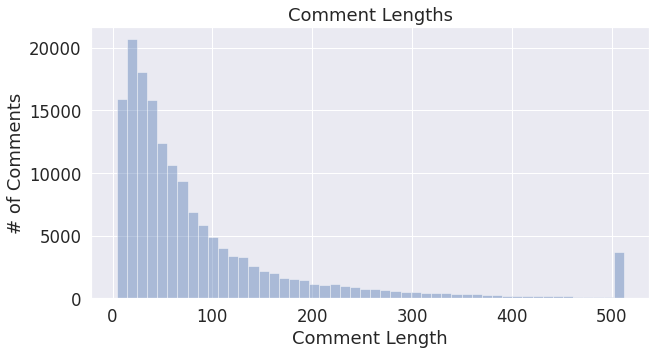

In [ ]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Truncate any comment lengths greater than 512.
trunc_lengths = [min(l, 512) for l in lengths]

# Plot the distribution of comment lengths.
sns.distplot(trunc_lengths, kde=False, rug=False)

# Alternatively, you might try using a log scale on the x-axis, but this is 
# tricky. See here for one approach:
# https://stackoverflow.com/questions/47850202/plotting-a-histogram-on-a-log-scale-with-matplotlib?rq=1
#plt.xscale('log')

plt.title('Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('# of Comments')

plt.show()

Clearly the majority of the comments are relatively short. Let's count up how many comments would be truncated based on different choices of `max_len`.

In [ ]:
# Cast the list to a numpy array so we can use some numpy features.
lengths = np.asarray(lengths)

# Get the total number of comments.
num_comments = len(lengths)

# Check the following lengths:
max_lens = [128, 256, 300, 400, 512]

print('How many comments will be truncated?\n')

# For each choice...
for max_len in max_lens:

    # Calculate how many comments will be truncacted.
    num_over = np.sum(lengths > max_len)

    # And as a percentage.
    prcnt_over = float(num_over) / float(num_comments)

    print(f'max_len = {max_len:}  -->  {num_over:>7,} of {num_comments:>7,}  ({prcnt_over:>5.1%}) will be truncated ')

How many comments will be truncated?

max_len = 128  -->   30,790 of 159,571  (19.3%) will be truncated 
max_len = 256  -->   11,063 of 159,571  ( 6.9%) will be truncated 
max_len = 300  -->    8,446 of 159,571  ( 5.3%) will be truncated 
max_len = 400  -->    5,160 of 159,571  ( 3.2%) will be truncated 
max_len = 512  -->    3,523 of 159,571  ( 2.2%) will be truncated 


There are several factors that impact our choice of the maximum sequence length `max_len`:
1. **Training Time** - Training time is quadratic with `max_len`. `max_len = 512` will take 4x  longer to train than `max_len = 256`, and 16x longer than `max_len = 128`!
2. **Accuracy** - Truncating the samples to a shorter length will presumably hurt accuracy, due to the loss of information. How much it hurts depends on the dataset.
3. **GPU Memory** - The combination of `max_len` and `batch_size` need to fit within the memory limits of our GPU. For a Tesla K80 (which has 12GB of RAM!), with `batch_size = 16`, the maximum length we can use (without running of memory) is about `max_len = 400`.

For this notebook, we'll use **`max_len = 128`** to speed up training times, and we'll see that BERT still delivers high accuracy on this benchmark, despite the truncation.


In [ ]:
max_len = 128

input_ids = []
attn_masks = []
labels = []

t0 = time.time()

# ======== Encoding ========

print(f'Encoding {len(train):,} training examples...')

# For every training example...
for (index, row) in train.iterrows():

    # Report progress.
    if ((len(input_ids) % 15000) == 0):
        print(f'  Encoded {len(input_ids):,} comments.')

    # Convert sentence pairs to input IDs, with attention masks.
    encoded_dict = tokenizer.encode_plus(row['comment_text'],  # The text to encode.
                                        max_length=max_len,    # Pad or truncate to this lenght.
                                        pad_to_max_length=True,
                                        truncation=True, 
                                        return_tensors='pt')   # Return objects as PyTorch tensors.

    # Add this example to our lists.
    input_ids.append(encoded_dict['input_ids'])
    attn_masks.append(encoded_dict['attention_mask'])
    
print(f'\nDONE. {len(input_ids):,} examples.')

# ======== List of Examples --> Tensor ========

# Convert each Python list of Tensors into a 2D Tensor matrix.
input_ids = torch.cat(input_ids, dim=0)
attn_masks = torch.cat(attn_masks, dim=0)

# ======== Prepare Labels ========

# Select the label columns for all examples.
labels = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

# The labels are either 0 or 1. Despite this, we need to cast the values to
# floats--otherwise our loss function will throw an error.
# https://discuss.pytorch.org/t/nn-bcewithlogitsloss-cant-accept-one-hot-target/59980
labels = labels.to_numpy().astype(float)

# Cast the labels list to a 2D Tensor.
labels = torch.tensor(labels)

# ======== Summary ========

print('\nData structure shapes:')
print(f'   input_ids:  {str(input_ids.shape):}')
print(f'  attn_masks:  {str(attn_masks.shape):}')
print(f'      labels:  {str(labels.shape):}')

print(f'\nEncoding took {(time.time() - t0):.0f} seconds')

Encoding 159,571 training examples...
  Encoded 0 comments.


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


  Encoded 15,000 comments.
  Encoded 30,000 comments.
  Encoded 45,000 comments.
  Encoded 60,000 comments.
  Encoded 75,000 comments.
  Encoded 90,000 comments.
  Encoded 105,000 comments.
  Encoded 120,000 comments.
  Encoded 135,000 comments.
  Encoded 150,000 comments.

DONE. 159,571 examples.

Data structure shapes:
   input_ids:  torch.Size([159571, 128])
  attn_masks:  torch.Size([159571, 128])
      labels:  torch.Size([159571, 6])

Encoding took 305 seconds


This dataset already has separate training and test sets, but we're going to further divide up our training set to use 90% for training and 10% for *validation*. This validation set will help us detect over-fitting during the training process.

In [ ]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attn_masks, labels)

# Create a 90-10 train-validation split. Calculate the number of samples to 
# include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


## Initialize Model with Pre-Trained Weights

In [ ]:
model = BertForMultiLabelSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 6,    
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
desc = model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not 

## Batch Size & DataLoaders

We'll also create a PyTorch DataLoader for our dataset. 

The DataLoader simply handles the creation of training batches for us. 

**Choice of Batch Size**

Training on a small batch of training samples at once (rather than one sample at a time) makes more efficient use of our GPU's parallel processing capabilities, and seems to even improve the model's accuracy.

The BERT authors recommend trying a batch size of either 16 or 32. For this Notebook, we'll be using a **batch size of 16**.

**Randomization**

The DataLoader for our training set will construct batches for us by randomly selecting different samples to put in each batch (each training sample will only appear in one batch, though!). 

Randomizing the training samples is considered good practice. Moreover, I believe the randomization is re-done for each training epoch (each pass through our training set), and that this can improve model accuracy.

For validation, it doesn't matter what order we execute in.

Our `model` object handles the execution of a forward pass, and the calculation of gradients during training. 

The actual updates to the model's weights, however, are performed by an Optimizer object. Here, we create that object and give it a reference to our model's parameters, as well as set some of our training hyperparameters.

For the purposes of fine-tuning, the authors recommend the following choices of learning rates: 5e-5, 3e-5, 2e-5  (We'll use 2e-5).

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation"

In [ ]:
# Specify our batch size.
batch_size = 16

# Create the DataLoaders for our training sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5,
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Number of training epochs (BERT authors recommend between 2 and 4)
epochs = 3

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))  


def good_update_interval(total_iters, num_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval 
    based on the magnitude of the total iterations.

    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the 
                              course of the for-loop.
    '''
    # Divide the total iterations by the desired number of updates. Most likely
    # this will be some ugly number.
    exact_interval = total_iters / num_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller. 
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

## Training loop


In [ ]:
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # Pick an interval on which to print progress updates.
    update_interval = good_update_interval(
                total_iters = len(train_dataloader), 
                num_desired_updates = 10
            )

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update.
        if (step % update_interval) == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This call returns the loss (because we provided labels) and the 
        # "logits"--the model outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
 
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_loss = 0

    predictions, true_labels = [], []

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():   
   

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Calculate the accuracy for this batch of test sentences.

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

    # Measure validation accuracy...

    # Combine the results across all batches. 
    flat_predictions = np.concatenate(predictions, axis=0)
    flat_true_labels = np.concatenate(true_labels, axis=0)

    # Calculate the validation accuracy.
    val_accuracy = roc_auc_score(flat_true_labels, flat_predictions, average='macro')

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch   900  of  8,976.    Elapsed: 0:01:56.
  Batch 1,800  of  8,976.    Elapsed: 0:03:52.
  Batch 2,700  of  8,976.    Elapsed: 0:05:48.
  Batch 3,600  of  8,976.    Elapsed: 0:07:44.
  Batch 4,500  of  8,976.    Elapsed: 0:09:40.
  Batch 5,400  of  8,976.    Elapsed: 0:11:37.
  Batch 6,300  of  8,976.    Elapsed: 0:13:33.
  Batch 7,200  of  8,976.    Elapsed: 0:15:29.
  Batch 8,100  of  8,976.    Elapsed: 0:17:25.

  Average training loss: 0.05
  Training epcoh took: 0:19:18

Running Validation...
  Accuracy: 0.99
  Validation Loss: 0.04
  Validation took: 0:00:37

======== Epoch 2 / 3 ========
Training...
  Batch   900  of  8,976.    Elapsed: 0:01:56.
  Batch 1,800  of  8,976.    Elapsed: 0:03:52.
  Batch 2,700  of  8,976.    Elapsed: 0:05:48.
  Batch 3,600  of  8,976.    Elapsed: 0:07:44.
  Batch 4,500  of  8,976.    Elapsed: 0:09:40.
  Batch 5,400  of  8,976.    Elapsed: 0:11:36.
  Batch 6,300  of  8,976.    Elapsed: 0:13:32.
  Batch 7

## Training Results

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.05,0.04,0.99,0:19:18,0:00:37
2,0.03,0.04,0.99,0:19:16,0:00:37
3,0.02,0.04,0.99,0:19:21,0:00:37


We can plot the training loss and validation loss to check if our model is overfitting.

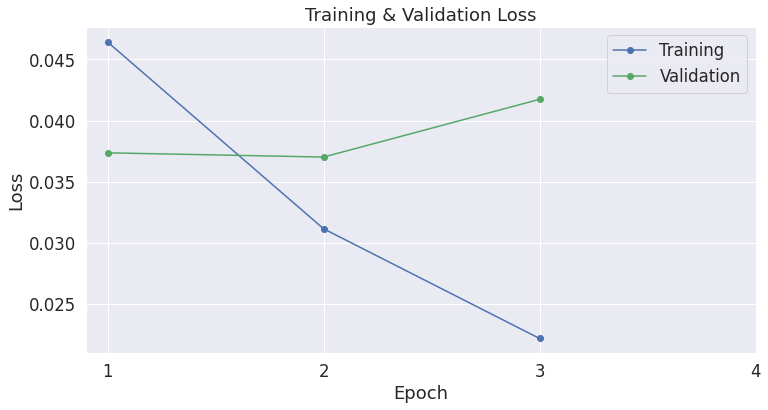

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

Looks like we're over-fitting a bit on the third epoch.

## Prepare test set

In [ ]:
# Load the test set files.
test = pd.read_csv('./data/test.csv')
test_labels = pd.read_csv('./data/test_labels.csv')

print('There are {:,} total test examples.'.format(len(test)))

# The unlabeled test samples are indicated by all of the label values being
# "-1" for that sample.

# Select only the labeled test samples.
test = test[test_labels.toxic != - 1]
test_labels = test_labels.loc[test_labels.toxic != -1]

print('There are {:,} labeled test examples.'.format(len(test)))

input_ids = []
attn_masks = []
labels = []

# ======== Encoding ========

print('Encoding all {:,} test samples...'.format(len(test)))

# For every test sample...
for (index, row) in test.iterrows():

    # Report progress.
    if ((len(input_ids) % 5000) == 0):
        print('  Tokenized {:,} comments.'.format(len(input_ids)))

    # Convert sentence pairs to input IDs, with attention masks.
    encoded_dict = tokenizer.encode_plus(row['comment_text'],  # The text to encode.
                                        max_length=max_len,    # Pad or truncate to this lenght.
                                        pad_to_max_length=True,
                                        truncation=True, 
                                        return_tensors='pt')   # Return objects as PyTorch tensors.

    # Add this example to our lists.
    input_ids.append(encoded_dict['input_ids'])
    attn_masks.append(encoded_dict['attention_mask'])
    
print('\nDONE. {:,} examples.'.format(len(input_ids)))

# ======== List of Examples --> Tensor ========

# Convert each Python list of Tensors into a 2D Tensor matrix.
input_ids = torch.cat(input_ids, dim=0)
attn_masks = torch.cat(attn_masks, dim=0)

There are 153,164 total test examples.
There are 63,978 labeled test examples.
Encoding all 63,978 test samples...
  Tokenized 0 comments.


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


  Tokenized 5,000 comments.
  Tokenized 10,000 comments.
  Tokenized 15,000 comments.
  Tokenized 20,000 comments.
  Tokenized 25,000 comments.
  Tokenized 30,000 comments.
  Tokenized 35,000 comments.
  Tokenized 40,000 comments.
  Tokenized 45,000 comments.
  Tokenized 50,000 comments.
  Tokenized 55,000 comments.
  Tokenized 60,000 comments.

DONE. 63,978 examples.


In [ ]:
# Remove the 'id' column.
#test_labels = test_labels[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
del test_labels['id']

# The labels are either 0 or 1. Despite this, we need to cast the values to
# floats--otherwise our loss function will throw an error.
# https://discuss.pytorch.org/t/nn-bcewithlogitsloss-cant-accept-one-hot-target/59980
labels = test_labels.to_numpy().astype(float)

# Cast the labels list to a 2D Tensor.
labels = torch.tensor(labels)

# ======== Summary ========

print('\nData structure shapes:')
print('   input_ids:  {:}'.format(str(input_ids.shape)))
print('  attn_masks:  {:}'.format(str(attn_masks.shape)))
print('      labels:  {:}'.format(str(labels.shape)))


Data structure shapes:
   input_ids:  torch.Size([63978, 128])
  attn_masks:  torch.Size([63978, 128])
      labels:  torch.Size([63978, 6])


In [ ]:
# Combine the training inputs into a TensorDataset.
test_dataset = TensorDataset(input_ids, attn_masks, labels)

# Specify our batch size.
batch_size = 16

# Create the DataLoader, which will select batches for us. For testing, the
# order we evaluate the samples in doesn't matter, so we'll just use the 
# "SequentialSampler" to read them in order.
test_dataloader = DataLoader(
            test_dataset,  # The training samples.
            sampler = SequentialSampler(test_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )


In [ ]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

t0 = time.time()

# Tracking variables 
predictions , true_labels = [], []

print('Evaluating on {:,} test set batches...'.format(len(test_dataloader)))

# Predict 
for batch in test_dataloader:
    
    # Report progress.
    if ((len(predictions) % 500) == 0):
        print('  Batch {:>5,}  of  {:>5,}.'.format(len(predictions), len(test_dataloader)))

    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store the compute graph, saving memory 
    # and speeding up prediction
    with torch.no_grad():
        
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

print('Evaluation took {:.0f} seconds.'.format(time.time() - t0))

Evaluating on 3,999 test set batches...
  Batch     0  of  3,999.
  Batch   500  of  3,999.
  Batch 1,000  of  3,999.
  Batch 1,500  of  3,999.
  Batch 2,000  of  3,999.
  Batch 2,500  of  3,999.
  Batch 3,000  of  3,999.
  Batch 3,500  of  3,999.
    DONE.
Evaluation took 147 seconds.


We collected the predictions in batches, so now we just need to recombine them.

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

The accuracy metric chosen by the authors for this dataset is the "ROC AUC" (Receiver Operating Characteristic, Area Under the Curve) rather than straight accuracy (number right / total examples).

The ROC AUC takes into account the fact that you can adjust the threshold to trade off false positives and false negatives, and yields a score which tries to capture overall accuracy independent of where you choose to put that threshold.

In [ ]:
# Calcualte the ROC AUC score for our model's predictions.
score = roc_auc_score(flat_true_labels, flat_predictions)

print('ROC AUC: {:.4f}'.format(score))

ROC AUC: 0.9843


## Baseline ROC AUC Accuracy

A good way to sanity check a performance score is to see how well you would do using just random guessing.

In this case, we know that the classes are very imbalanced, and that ~90% of the comments don't contain anything toxic.

If we just predicted zero for every test sample...

In [ ]:
zero_preds = np.zeros(flat_predictions.shape)

# Calcualte the ROC AUC score for predicting all 0s.
score = roc_auc_score(flat_true_labels, zero_preds)

print('Predict all zeros --> ROC AUC: {:.3f}'.format(score))

Predict all zeros --> ROC AUC: 0.500
